# Looking at downloading the publically avilable ftp datasets from ECMWF

**Created:** Leo Peach

**Purpose:** Downloading files from the ECMWF ftp data servers

In [1]:
from ftplib import FTP

Inside the corporate proxy we need to send the request to the proxy and then include where we really want to go in the username.

In [2]:
#ftp proxy required for work
site = FTP("gw-ftp.dmz")
msg = site.login('wmo@dissemination.ecmwf.int', 'essential')
#site = FTP("dissemination.ecmwf.int")
#msg = site.login('wmo', 'essential')


Now lets use the connect to get a list of folders on the highest level

In [3]:

files = []

try:
    files = site.nlst()
except ftplib.error_perm:
    if str(resp) == "550 No files found":
        print("No files in this directory")
    else:
        raise

#ite.cwd('/20190206000000')
#site.retrlines('LIST')
#dataList = site.dir()

fortunately the server provides the folders in date order, we can use the last date to change the directory and go into the latest available forecasts

In [4]:
site.cwd("/"+files[-1])

'250 CWD command successful'

now grab a new file list

In [5]:
files = []

try:
    files = site.nlst()
except ftplib.error_perm:
    if str(resp) == "550 No files found":
        print("No files in this directory")
    else:
        raise
#site.close()

In [6]:
files[0:10]

['A_HVXA85ECMF071200_C_ECMF_20190207120000_an_v_850hPa_global_0p5deg_grib2.bin',
 'A_HUXA85ECMF071200_C_ECMF_20190207120000_an_u_850hPa_global_0p5deg_grib2.bin',
 'A_HTXA85ECMF071200_C_ECMF_20190207120000_an_t_850hPa_global_0p5deg_grib2.bin',
 'A_HPXA89ECMF071200_C_ECMF_20190207120000_an_msl_global_0p5deg_grib2.bin',
 'A_HHXA50ECMF071200_C_ECMF_20190207120000_an_gh_500hPa_global_0p5deg_grib2.bin',
 'A_HVXE85ECMF071200_C_ECMF_20190207120000_24h_v_850hPa_global_0p5deg_grib2.bin',
 'A_HUXE85ECMF071200_C_ECMF_20190207120000_24h_u_850hPa_global_0p5deg_grib2.bin',
 'A_HTXE85ECMF071200_C_ECMF_20190207120000_24h_t_850hPa_global_0p5deg_grib2.bin',
 'A_HPXE89ECMF071200_C_ECMF_20190207120000_24h_msl_global_0p5deg_grib2.bin',
 'A_HHXE50ECMF071200_C_ECMF_20190207120000_24h_gh_500hPa_global_0p5deg_grib2.bin']

There are tonnes of files lets for now choose the msl pressure one, the ecmwf website helps with working out what is what (https://www.ecmwf.int/en/forecasts/datasets/wmo-essential), we will look at mean sea level pressure for now.

In [7]:
msl_files = []
for file in files:
    if 'msl' in file:
        if 'em' in file:
            continue
        if 'es' in file:
            continue
        msl_files.append(file)
msl_files

['A_HPXA89ECMF071200_C_ECMF_20190207120000_an_msl_global_0p5deg_grib2.bin',
 'A_HPXE89ECMF071200_C_ECMF_20190207120000_24h_msl_global_0p5deg_grib2.bin',
 'A_HPXI89ECMF071200_C_ECMF_20190207120000_48h_msl_global_0p5deg_grib2.bin',
 'A_HPXK89ECMF071200_C_ECMF_20190207120000_72h_msl_global_0p5deg_grib2.bin',
 'A_HPXM89ECMF071200_C_ECMF_20190207120000_96h_msl_global_0p5deg_grib2.bin',
 'A_HPXO89ECMF071200_C_ECMF_20190207120000_120h_msl_global_0p5deg_grib2.bin',
 'A_HPXQ89ECMF071200_C_ECMF_20190207120000_144h_msl_global_0p5deg_grib2.bin',
 'A_HPXS89ECMF071200_C_ECMF_20190207120000_168h_msl_global_0p5deg_grib2.bin',
 'A_HPXW89ECMF071200_C_ECMF_20190207120000_192h_msl_global_0p5deg_grib2.bin',
 'A_HPXY89ECMF071200_C_ECMF_20190207120000_216h_msl_global_0p5deg_grib2.bin',
 'A_HPXT89ECMF071200_C_ECMF_20190207120000_240h_msl_global_0p5deg_grib2.bin']

In [8]:
filename = 'mytempgrib.grib'

localfile = open(filename, 'wb')
try:
    site.retrbinary('RETR ' + msl_files[0], localfile.write, 1024)
except:
    print("Error")
localfile.close()


#write file to memory
#investigated, currently not supported in a number of libraries
#import io
#bio = io.BytesIO()

#resp = site.retrbinary('RETR '+msl_files[0], bio.write,1024)
#bio.seek(0) # Go back to the start

#site.quit()
#localfile.close()

Now we need to read in that file and convert it to something we can use

In [20]:
import xarray as xr
import matplotlib.pyplot as plt

In [31]:
ds = xr.open_dataset('/home/leo/Documents/Python/ECMWF_projects/mytempgrib_1.grib', engine='cfgrib')

Ignoring index file '/home/leo/Documents/Python/ECMWF_projects/mytempgrib_1.grib.e1158.idx' older than GRIB file


In [37]:
time = ds.time.data

In [41]:
time + np.timedelta64(24, 'h')

numpy.datetime64('2019-02-08T12:00:00.000000000')

In [23]:
ds.longitude.values.shape

(720,)

Lets make a plot

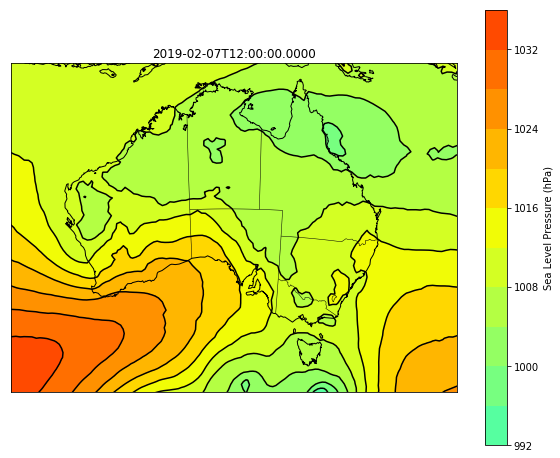

In [19]:
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
import os
import io
import numpy as np


pres_max = 1010.0
pres_min = 990.0
fig, axes = plt.subplots(figsize=(10,8))

#Coords for centre of Australia
lon_0 = 134 
lat_0 = -23


if (ds.msl.values /100).max() > pres_max:
        pres_max = (ds.msl.values /100).max()
if (ds.msl.values /100).min() < pres_max:    
        pres_min = (ds.msl.values /100).min()
    
    
map_ax = Basemap(resolution='l',projection='tmerc', lat_0=lat_0,lon_0=lon_0, llcrnrlon=100, llcrnrlat=-42
               ,urcrnrlon=160, urcrnrlat=-8.0)
lon, lat = np.meshgrid(ds.longitude.data, ds.latitude.data)
xi, yi = map_ax(lon, lat)
map_ax.contour(xi, yi, (ds.msl.values /100), 10, vmin = pres_min, vmax = pres_max, colors="black")
im = map_ax.contourf(xi, yi,(ds.msl.values/100), 10, vmin = pres_min, vmax = pres_max, cmap=plt.get_cmap("jet"))
m = plt.cm.ScalarMappable(cmap=cm.coolwarm)
m.set_array((ds.msl.values /100))
m.set_clim(pres_min, pres_max)
# Add a color bar
cbar = plt.colorbar(im, boundaries=np.arange(pres_min,pres_max,4))
cbar.set_label('Sea Level Pressure (hPa)')
map_ax.drawcoastlines()
map_ax.drawstates()
plt.title(str(ds.time.values)[:-5])
buf = io.BytesIO()
plt.savefig(buf, format='png')
#maps.append(Image.open(buf))